## Import important libraries

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import os
import warnings
from scipy import stats
from sklearn.cluster import KMeans
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from category_encoders import MEstimateEncoder
import optuna
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')

## Dataset information

In [79]:
# train path:
train_path = '../data/train.csv'
# test path:
test_path = '../data/test.csv'
# load train data:
train = pd.read_csv(train_path, index_col='Id')
test = pd.read_csv(test_path, index_col='Id')
print(train.head())
print('Train data contains {} rows and {} features'.format(train.shape[0], train.shape[1]))

print(test.head())
print('Test data contains {} rows and {} features'.format(test.shape[0], test.shape[1]))

    MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                  ...                                     
1          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
2          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
3          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
4          Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
5          Lvl    AllPub       FR2  ... 

### Missing values

In [80]:
# Concat test and train data:
all_data = pd.concat([train, test])
all_data.tail(10)

# Vsiualize the percentages of missing values per features:
missing_values = pd.DataFrame({'Percentage' : (all_data.isnull().sum()/len(all_data)) * 100}, 
                              index=all_data.columns)
missing_values = missing_values[missing_values['Percentage']>0].sort_values(
    by='Percentage', 
    ascending=False)
missing_values.drop(index='SalePrice', inplace=True)
missing_values.head(10)



,Percentage
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
MasVnrType,60.500171
FireplaceQu,48.646797
LotFrontage,16.649538
GarageCond,5.447071
GarageYrBlt,5.447071
GarageFinish,5.447071


In [81]:
#choose the column names that have more than 50% missing values:
missing_cols = missing_values[missing_values['Percentage']>50].index.tolist()
#change to dictionary:
missing_cols_dict = {col: all_data[col].dtype for col in missing_cols}
missing_cols_dict

{'PoolQC': dtype('O'),
 'MiscFeature': dtype('O'),
 'Alley': dtype('O'),
 'Fence': dtype('O'),
 'MasVnrType': dtype('O')}

### Categorical and continuous columns

In [82]:
continuous_features = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = train.select_dtypes(include=['object']).columns.tolist()
continuous_features.remove('SalePrice')
print('There are {} continuous features and {} categorical features'.format(len(continuous_features), len(categorical_features)))
print('Continuous features: ', continuous_features)
print('Categorical features: ', categorical_features)   

There are 36 continuous features and 43 categorical features
Continuous features:  ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
Categorical features:  ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Elect

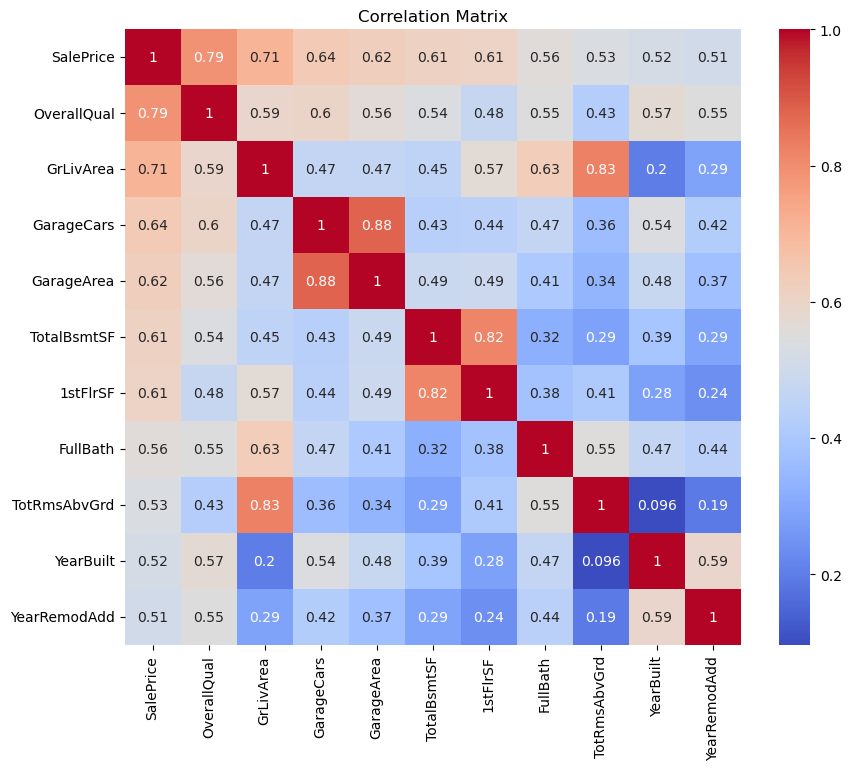

In [83]:
# Calculating correlations :
train_corr = train.select_dtypes(include=[np.number])
# Calculating correlations:
corr = train_corr.corr()
# Sorting correlations with SalePrice:
corr_sorted = corr['SalePrice'].abs().sort_values(ascending=False)
corr_high = corr_sorted[corr_sorted>0.5].index
# Subsetting correlations:
corr = corr.loc[corr_high, corr_high]
# Visualize the heatmap:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

## Baseline 0.12590
* preserve all the features
* fill NA with median value
* single XGBoost model

In [84]:
train = pd.read_csv('../data/train.csv')
test  = pd.read_csv('../data/test.csv')

test_id = test['Id']

train.drop(['Id'], axis=1, inplace=True)

continuous_columns = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
continuous_columns.remove('SalePrice')

discret_columns = train.select_dtypes(include=['object']).columns.tolist()

for col in continuous_columns:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(test[col].median())

for col in discret_columns:
    train[col].fillna('-1',inplace=True)
    test[col].fillna('-1',inplace=True)
    res1 = train[col].value_counts().keys()
    res2 = test[col].value_counts().keys()
    res = sorted(list(set(res1).union(set(res2))))
    mapping = dict(zip(res, range(len(res))))
    print(f'{col}:{mapping}')
    train[col] = train[col].map(mapping)
    test[col] = test[col].map(mapping)

train.to_csv('../data/train_pro.csv',index=False)
test.to_csv('../data/test_pro.csv',index=False)


MSZoning:{'-1': 0, 'C (all)': 1, 'FV': 2, 'RH': 3, 'RL': 4, 'RM': 5}
Street:{'Grvl': 0, 'Pave': 1}
Alley:{'-1': 0, 'Grvl': 1, 'Pave': 2}
LotShape:{'IR1': 0, 'IR2': 1, 'IR3': 2, 'Reg': 3}
LandContour:{'Bnk': 0, 'HLS': 1, 'Low': 2, 'Lvl': 3}
Utilities:{'-1': 0, 'AllPub': 1, 'NoSeWa': 2}
LotConfig:{'Corner': 0, 'CulDSac': 1, 'FR2': 2, 'FR3': 3, 'Inside': 4}
LandSlope:{'Gtl': 0, 'Mod': 1, 'Sev': 2}
Neighborhood:{'Blmngtn': 0, 'Blueste': 1, 'BrDale': 2, 'BrkSide': 3, 'ClearCr': 4, 'CollgCr': 5, 'Crawfor': 6, 'Edwards': 7, 'Gilbert': 8, 'IDOTRR': 9, 'MeadowV': 10, 'Mitchel': 11, 'NAmes': 12, 'NPkVill': 13, 'NWAmes': 14, 'NoRidge': 15, 'NridgHt': 16, 'OldTown': 17, 'SWISU': 18, 'Sawyer': 19, 'SawyerW': 20, 'Somerst': 21, 'StoneBr': 22, 'Timber': 23, 'Veenker': 24}
Condition1:{'Artery': 0, 'Feedr': 1, 'Norm': 2, 'PosA': 3, 'PosN': 4, 'RRAe': 5, 'RRAn': 6, 'RRNe': 7, 'RRNn': 8}
Condition2:{'Artery': 0, 'Feedr': 1, 'Norm': 2, 'PosA': 3, 'PosN': 4, 'RRAe': 5, 'RRAn': 6, 'RRNn': 7}
BldgType:{'1Fam

## 划分训练集和验证集

In [85]:
def split_train_val(X, y, ratio=0.8, seed=42):
    """
    划分训练集和验证集
    :param X: 特征
    :param y: 标签
    :param ratio: 训练集比例
    :return: X_train, y_train, X_val, y_val
    """
    np.random.seed(seed)
    n = X.shape[0]
    y = y.astype(int)
    indices = np.arange(n)
    np.random.shuffle(indices)
    X, y = X[indices], y[indices]
    split = int(n * ratio)
    X_train, y_train = X[:split], y[:split]
    X_val, y_val = X[split:], y[split:]
    return X_train, y_train, X_val, y_val


### 训练

In [86]:
config={
    'ratio':0.8,
    'seed':42
}
df_train = pd.read_csv('../data/train_pro.csv')
data = df_train.values
n = data.shape[0]
X = data[:,:-1]
y = data[:,-1]

X_train, y_train, X_val, y_val = split_train_val(X, y, config.get('ratio'), seed=config.get('seed'))
#choose the best model
xgb_model = XGBRegressor(learning_rate=0.0156,n_estimators=4750,max_depth=3,min_child_weight=0,subsample=0.7,colsample_bytree=0.4064,nthread=-1,scale_pos_weight=2,seed=42)
xgb_model.fit(X_train,y_train, eval_set = [(X_val,y_val)])

[0]	validation_0-rmse:71514.65565
[1]	validation_0-rmse:70703.91814
[2]	validation_0-rmse:69996.68797
[3]	validation_0-rmse:69256.84203
[4]	validation_0-rmse:68495.74282
[5]	validation_0-rmse:67785.77937
[6]	validation_0-rmse:67292.47884
[7]	validation_0-rmse:66630.54872
[8]	validation_0-rmse:65980.21017
[9]	validation_0-rmse:65238.85501
[10]	validation_0-rmse:64649.22570
[11]	validation_0-rmse:64123.16870
[12]	validation_0-rmse:63446.43501
[13]	validation_0-rmse:62770.50664
[14]	validation_0-rmse:62113.63703
[15]	validation_0-rmse:61433.87662
[16]	validation_0-rmse:60837.62775
[17]	validation_0-rmse:60216.76209
[18]	validation_0-rmse:59712.46246
[19]	validation_0-rmse:59178.72245
[20]	validation_0-rmse:58572.34843
[21]	validation_0-rmse:58139.25015
[22]	validation_0-rmse:57598.09976
[23]	validation_0-rmse:57117.01909
[24]	validation_0-rmse:56588.21461
[25]	validation_0-rmse:56013.54270
[26]	validation_0-rmse:55503.04103
[27]	validation_0-rmse:54954.61957
[28]	validation_0-rmse:54485.9

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4064, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0156, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=0, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=4750, n_jobs=None, nthread=-1,
             num_parallel_tree=None, ...)

### 测试并提交

In [87]:
df_test = pd.read_csv('../data/test_pro.csv')
data_test = df_test.values
X_test = data_test[:,1:]
pred = xgb_model.predict(X_test)
pred_train = xgb_model.predict(X_train)
submission = pd.DataFrame({
    'Id': data_test[:,0].astype(int),  # Assuming test set has an 'Id' column
    'SalePrice': pred # Replace 'Target' with the name of your target column
})

# Save the submission file
submission.to_csv('../res/submission.csv', index=False)


## Feature Engineenring

In [88]:
# drop the columns that have more than 50% missing values:
df_train.drop(columns=missing_cols, inplace=True)
df_test.drop(columns=missing_cols, inplace=True)

# # drop the columns that have less than 0.5 correlation with SalePrice:
# corr_low = corr_sorted[corr_sorted<0.5].index.to_list()
# df_train.drop(columns=corr_low, inplace=True)
# df_test.drop(columns=corr_low, inplace=True)
print('Train data contains {} rows and {} features'.format(df_train.shape[0], df_train.shape[1]))
print('Test data contains {} rows and {} features'.format(df_test.shape[0], df_test.shape[1]))

Train data contains 1460 rows and 75 features
Test data contains 1459 rows and 75 features


## 再次训练

In [94]:
data = df_train.values
n = data.shape[0]
X = data[:,:-1]
y = data[:,-1]
# 定义超参数分布
param_dist = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.15, 0.2],
    'n_estimators': [4000, 4500, 5000]
}
from sklearn.metrics import mean_squared_error
#choose the best model
best_score = float('-inf')  # 初始化最优得分
X_train, y_train, X_val, y_val = split_train_val(X, y, config.get('ratio'), seed=config.get('seed'))
for lr in [0.005, 0.01, 0.015, 0.02, 0.03, 0.04, 0.05]:
    xgb_model = XGBRegressor(learning_rate=lr,n_estimators=4750,max_depth=3,min_child_weight=0,subsample=0.7,colsample_bytree=0.4064,nthread=-1,scale_pos_weight=2,seed=42)
    xgb_model.fit(X_train,y_train, eval_set = [(X_val,y_val)])
    print(f'learning_rate={lr}')
      # 进行预测并计算 RMSE
    y_pred = xgb_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))  # 计算 RMSE
    print(f'RMSE: {rmse}')  # 输出 RMSE

    # 可以选择基于 RMSE 来选择最佳模型
    if rmse < best_score or best_score == float('-inf'):  # 选择最小 RMSE
        best_score = rmse
        best_model = xgb_model
print(f'Best RMSE: {best_score}')

# 保存模型
import joblib
joblib.dump(xgb_model, 'best_model.pkl')


# 再次预测
data_test = df_test.values
X_test = data_test[:,1:]
pred = xgb_model.predict(X_test)

# 生成提交文件
submission = pd.DataFrame({
    'Id': data_test[:,0].astype(int),  # Assuming test set has an 'Id' column
    'SalePrice': pred # Replace 'Target' with the name of your target column
})
# Save the submission file
submission.to_csv('../res/submission_2.csv', index=False)


[0]	validation_0-rmse:72100.76848


[1]	validation_0-rmse:71868.04774
[2]	validation_0-rmse:71633.22872
[3]	validation_0-rmse:71377.20468
[4]	validation_0-rmse:71133.12883
[5]	validation_0-rmse:70881.87073
[6]	validation_0-rmse:70617.95181
[7]	validation_0-rmse:70366.00339
[8]	validation_0-rmse:70157.08150
[9]	validation_0-rmse:69913.10178
[10]	validation_0-rmse:69699.46958
[11]	validation_0-rmse:69466.21649
[12]	validation_0-rmse:69254.64020
[13]	validation_0-rmse:69039.31434
[14]	validation_0-rmse:68818.78882
[15]	validation_0-rmse:68599.74441
[16]	validation_0-rmse:68355.85697
[17]	validation_0-rmse:68116.78302
[18]	validation_0-rmse:67869.37804
[19]	validation_0-rmse:67648.11285
[20]	validation_0-rmse:67421.12692
[21]	validation_0-rmse:67178.74537
[22]	validation_0-rmse:66988.62311
[23]	validation_0-rmse:66794.04774
[24]	validation_0-rmse:66583.03467
[25]	validation_0-rmse:66355.38449
[26]	validation_0-rmse:66119.91240
[27]	validation_0-rmse:65909.42652
[28]	validation_0-rmse:65730.90605
[29]	validation_0-rmse:65523.

[0]	validation_0-rmse:0.51583
[1]	validation_0-rmse:0.50539
[2]	validation_0-rmse:0.49308
[3]	validation_0-rmse:0.48126
[4]	validation_0-rmse:0.47143
[5]	validation_0-rmse:0.46180
[6]	validation_0-rmse:0.45315
[7]	validation_0-rmse:0.44280
[8]	validation_0-rmse:0.43475
[9]	validation_0-rmse:0.42556
[10]	validation_0-rmse:0.41890
[11]	validation_0-rmse:0.41186
[12]	validation_0-rmse:0.40554
[13]	validation_0-rmse:0.39979
[14]	validation_0-rmse:0.39387
[15]	validation_0-rmse:0.38833
[16]	validation_0-rmse:0.38294
[17]	validation_0-rmse:0.37763
[18]	validation_0-rmse:0.37227
[19]	validation_0-rmse:0.36791
[20]	validation_0-rmse:0.36378
[21]	validation_0-rmse:0.35866
[22]	validation_0-rmse:0.35495
[23]	validation_0-rmse:0.35017
[24]	validation_0-rmse:0.34668
[25]	validation_0-rmse:0.34348
[26]	validation_0-rmse:0.33977
[27]	validation_0-rmse:0.33676
[28]	validation_0-rmse:0.33440
[29]	validation_0-rmse:0.33066
[30]	validation_0-rmse:0.32802
[31]	validation_0-rmse:0.32495
[32]	validation_0-